# Image Classification

We will use keras.sequential model for this exercise.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf 

from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential 

Download and explore the dataset 
This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin = dataset_url, untar = True )
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


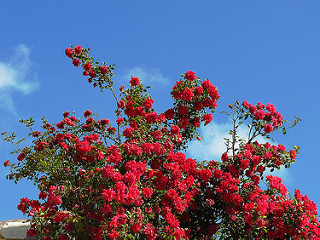

In [4]:
# some roses 
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

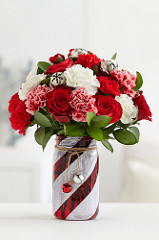

In [5]:
PIL.Image.open(str(roses[1]))

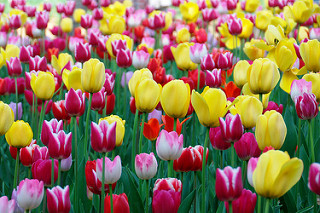

In [6]:
# Tulips 

tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

## Load using keras.preprocessing 

Let's load these images off disk using the helpful image_dataset_from_directory utility.

## Create Dataset 


In [7]:
# define some parameters for the loader 

batch_size = 32 
img_height = 180
img_width = 180 

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


We can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualizing the data 

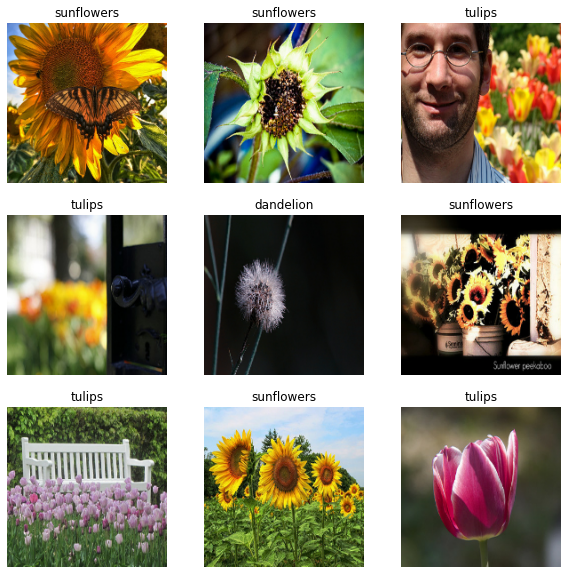

In [12]:
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to model.fit in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [13]:
for image_batch, labels_batch in train_ds : 
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

To convert them to numpy.ndarray, we will use numpy()

## Configure the dataset for performance 

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

## Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using a Rescaling layer.

In [15]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [16]:
normalized_ds = train_ds.map(lambda x,y : (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.98584765


We can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

## Create the model 

Using three convolution blocks with a max pool layer in each of them

In [17]:
num_classes  = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16,3, padding = 'same', activation= 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding = 'same', activation= 'relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation= 'relu'),
  layers.Dense(num_classes)

                    
])

## Compile the model 



In [18]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
              metrics = ['accuracy'])

## Model Summary 

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train The Model 

In [20]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10
92/92 [==============================] - 92s 995ms/step - loss: 1.3114 - accuracy: 0.4411 - val_loss: 1.1941 - val_accuracy: 0.5136
Epoch 2/10
92/92 [==============================] - 90s 978ms/step - loss: 0.9766 - accuracy: 0.6199 - val_loss: 0.9348 - val_accuracy: 0.6540
Epoch 3/10
92/92 [==============================] - 91s 988ms/step - loss: 0.7726 - accuracy: 0.7115 - val_loss: 0.9315 - val_accuracy: 0.6362
Epoch 4/10
92/92 [==============================] - 91s 992ms/step - loss: 0.5270 - accuracy: 0.8161 - val_loss: 1.0312 - val_accuracy: 0.6349
Epoch 5/10
92/92 [==============================] - 92s 1s/step - loss: 0.3338 - accuracy: 0.8781 - val_loss: 1.3427 - val_accuracy: 0.5899
Epoch 6/10
92/92 [==============================] - 92s 1s/step - loss: 0.2080 - accuracy: 0.9336 - val_loss: 1.3775 - val_accuracy: 0.6403
Epoch 7/10
92/92 [==============================] - 91s 993ms/step - loss: 0.0896 - accuracy: 0.9765 - val_loss: 1.9640 - val_accuracy: 0.6253
Epoch

## Visualizing the training results 



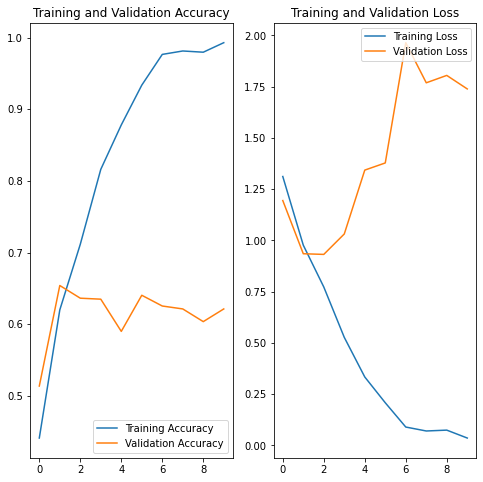

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = "Training Accuracy")
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting 

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add Dropout to your model.

## Data Augmentation 

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from tf.keras.layers.experimental.preprocessing. These can be included inside your model like other layers, and run on the GPU.

In [23]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal",
                                                  input_shape = (img_height,
                                                                 img_width,
                                                                 3)),
     layers.experimental.preprocessing.RandomRotation(0.1),
     layers.experimental.preprocessing.RandomZoom(0.1)
     
    ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

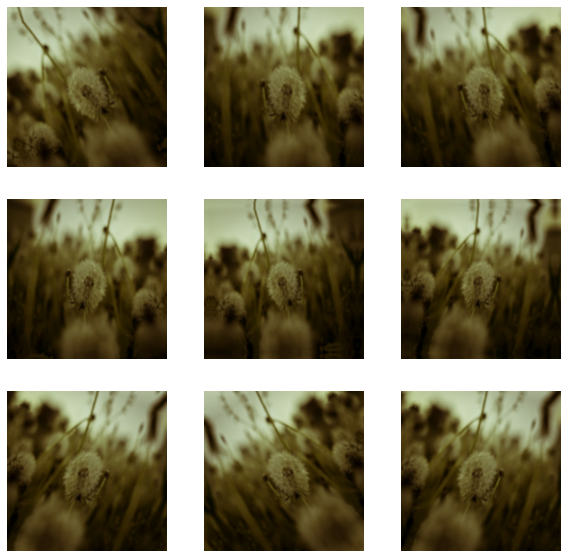

In [24]:
plt.figure(figsize = (10, 10))

for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

##Dropout

Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using layers.Dropout, then train it using augmented images.

In [26]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation= 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding = 'same', activation= 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding = 'same', activation= 'relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation= 'relu'),
  layers.Dense(num_classes)
])

In [27]:
# Compile and train 

model.compile(optimizer= 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
              metrics = ['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 45, 45, 64)       

In [30]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/15
92/92 [==============================] - 105s 1s/step - loss: 0.5026 - accuracy: 0.8096 - val_loss: 0.7412 - val_accuracy: 0.7316
Epoch 2/15
92/92 [==============================] - 105s 1s/step - loss: 0.4902 - accuracy: 0.8147 - val_loss: 0.7126 - val_accuracy: 0.7343
Epoch 3/15
92/92 [==============================] - 105s 1s/step - loss: 0.4568 - accuracy: 0.8225 - val_loss: 0.6943 - val_accuracy: 0.7248
Epoch 4/15
92/92 [==============================] - 105s 1s/step - loss: 0.4628 - accuracy: 0.8294 - val_loss: 0.6583 - val_accuracy: 0.7480
Epoch 5/15
92/92 [==============================] - 105s 1s/step - loss: 0.4457 - accuracy: 0.8317 - val_loss: 0.7604 - val_accuracy: 0.7139
Epoch 6/15
92/92 [==============================] - 105s 1s/step - loss: 0.4100 - accuracy: 0.8443 - val_loss: 0.7848 - val_accuracy: 0.7384
Epoch 7/15
92/92 [==============================] - 106s 1s/step - loss: 0.3812 - accuracy: 0.8539 - val_loss: 0.6856 - val_accuracy: 0.7589
Epoch 8/15
92

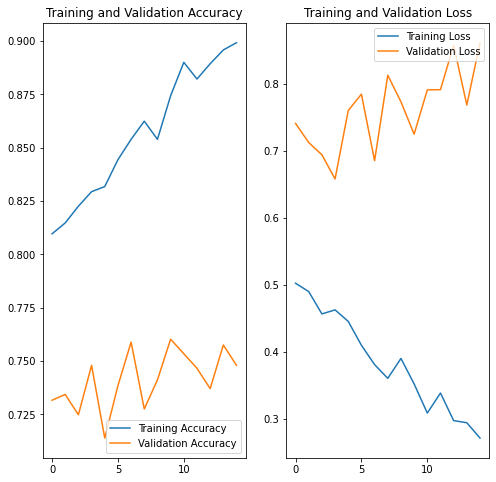

In [31]:
# visualizing 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction 

In [32]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin = sunflower_url)


img = keras.preprocessing.image.load_img(
    sunflower_path, target_size = (img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    
)

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to sunflowers with a 100.00 percent confidence.
